In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import gzip
import pickle
import torch

# Imágenes astronómicas

Las imágenes astrónomicas usualmente se guardan en formato FITS

Podemos usar la librería [astropy](https://docs.astropy.org/en/stable/io/fits/) para abrir y manipular estos archivos

El repositorio tiene una imagen de ejemplo en la carpeta `../data`

Algunos atributos importantes son
- `info()` para explorar el contenido del archivo
- `header` para recuperar los parámetros que se usaron para producir la imagen y otra metadata
- `data` para recuperar la imagen en si

Como la imagen tiene "valores extremos" usamos visualizamos su logaritmo

<IPython.core.display.Javascript object>


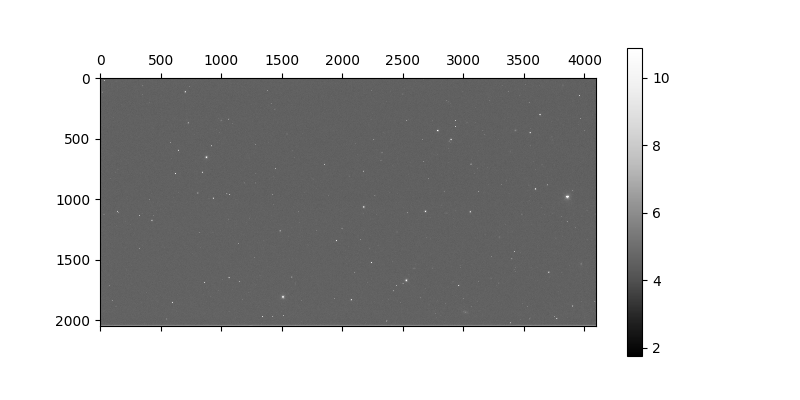

Filename: data/example.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     251   (2048, 4096)   float32   
  1                2 ImageHDU        11   (2048, 4096)   int16 (rescales to uint16)   


None

In [2]:
fig, ax = plt.subplots(figsize=(8, 4))
with gzip.open('data/example.fits.gz') as f:
    with fits.open(f) as hdul:
        display(hdul.info())
        #print(repr(hdul[0].header))
        imap = ax.matshow(np.log(1+hdul[0].data).T, cmap=plt.cm.Greys_r)
        fig.colorbar(imap, ax=ax)

# Detección de transientes y variables con resta de imágenes

<img src="img/image-subtraction.png" width="800">

<img src="img/image-candidates.png" width="800">

<img src="img/image-pipeline.png" width="800">

Usaremos un conjunto de candidatos a transiente obtenidos luego del paso de sustración de imágenes durante el proyecto High Cadence Transient Survey (HiTS) el año 2013

Los candidatos están etiquetados como

- 0 : Candidato real (dominado por artefactos)
- 1 : Candidato sintético insertado en la pipeline

Se [insertaron candidatos sintéticos](https://iopscience.iop.org/article/10.1086/519832/meta) para balancear el dataset y entrenar un clasificador, originalmente un [random forest](https://iopscience.iop.org/article/10.3847/0004-637X/832/2/155/meta) y luego una [red neuronal convolucional](https://iopscience.iop.org/article/10.3847/1538-4357/836/1/97/pdf)

Cada candidato está representado por tres imágenes de 21x21 pixeles

- 0: Imagen de diferencia
- 1: Imagen de ciencia
- 2: Imagen de referencia

In [3]:
from torch.utils.data import TensorDataset, DataLoader, Subset 

with gzip.open("data/images2.pgz", mode="r") as f:
    astro_image, astro_label = pickle.load(f)

# Reescalamiento a [0, 1]
astro_image_tensor = torch.from_numpy(astro_image.astype('float32')).reshape(-1, 3, 21, 21)
im_min = astro_image_tensor.min(dim=-1).values.min(dim=-1).values.reshape(-1, 3, 1, 1)
im_max = astro_image_tensor.max(dim=-1).values.max(dim=-1).values.reshape(-1, 3, 1, 1)
astro_image_tensor = (astro_image_tensor - im_min)/(im_max-im_min)

# Creación de DataSet y DataLoader
astro_dataset = TensorDataset(astro_image_tensor, torch.from_numpy(astro_label))

astro_loader = DataLoader(astro_dataset, 
                          batch_size=128, 
                          shuffle=True)

<IPython.core.display.Javascript object>


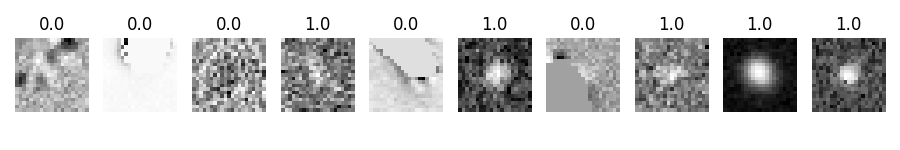

In [4]:
for x, y in astro_loader:
    break
    
fig, ax = plt.subplots(1, 10, figsize=(9, 1.5), tight_layout=True)
for axi, xi, yi in zip(ax, x, y):
    axi.imshow(xi[0], cmap=plt.cm.Greys_r)
    axi.axis('off')
    axi.set_title(yi.item())


El conjunto completo está en `/home/shared/astro/HiTS/HiTS_500k/images_train.csv` como archivo csv

# Tarea final Unidad 5

- Entrenar un GAN con **las imágenes de diferencia** de HiTS
- Reescale las imágenes al rango $[0, 1]$
- Utilice como base la arquitectura [DCGAN](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
- Son libres de experimentar, se premiará la creatividad
- Se trabajará en grupos de a dos
- Recomiendo usar guanaco para hacer los entrenamientos en GPU. Puede usar el ambiente de conda `astro`

In [5]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [6]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 4

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 21

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 21

# Size of feature maps in discriminator
ndf = 21

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


<IPython.core.display.Javascript object>


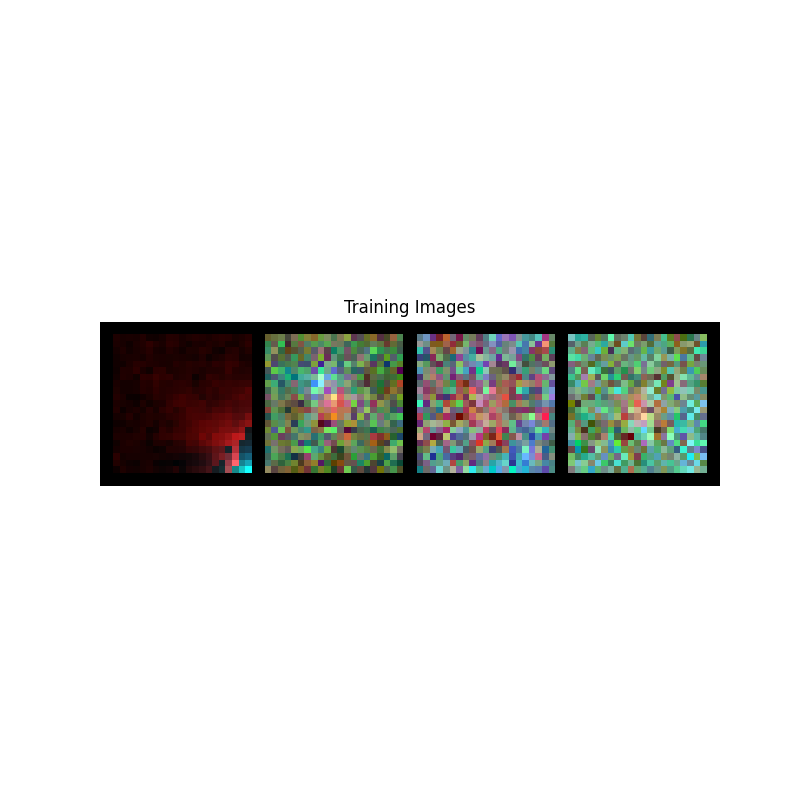

In [19]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

from torch.utils.data import TensorDataset, DataLoader, Subset 

with gzip.open("data/images2.pgz", mode="r") as f:
    astro_image, astro_label = pickle.load(f)

# Reescalamiento a [0, 1]
astro_image_tensor = torch.from_numpy(astro_image.astype('float32')).reshape(-1, 3, 21, 21)
im_min = astro_image_tensor.min(dim=-1).values.min(dim=-1).values.reshape(-1, 3, 1, 1)
im_max = astro_image_tensor.max(dim=-1).values.max(dim=-1).values.reshape(-1, 3, 1, 1)
astro_image_tensor = (astro_image_tensor - im_min)/(im_max-im_min)

# Creación de DataSet y DataLoader
dataset = TensorDataset(astro_image_tensor, torch.from_numpy(astro_label))

dataloader = DataLoader(astro_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)




# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)), cmap=plt.cm.Greys_r)

In [65]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [66]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [67]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 168, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(168, 84, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(84, 42, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(42, 21, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(21, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [72]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
            # input is (nc) x 21 x 21
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.act1 = nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf) x 10 x 10
        
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(ndf * 2)
        self.act2 = nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf*2) x 5 x 5
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
        self.act3 = nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf*4) x 2 x 2
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 8)
        self.act4 = nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf*8) x 1 x 1
        self.conv5 = nn.Conv2d(ndf * 8, 1, 1, 1, 0, bias=False)
        self.fin = nn.Sigmoid()

    def forward(self, x):
        
        x = self.act1(self.conv1(x))
        x = self.act2(self.bn1(self.conv2(x)))
        
        x = self.act3(self.bn2(self.conv3(x)))
        
        x = self.act4(self.bn3(self.conv4(x)))
        
        x = self.fin(self.conv5(x))
        return x

In [73]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (conv1): Conv2d(3, 21, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (act1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(21, 42, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(42, 84, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(84, 168, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act4): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv5): Conv2d(168, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (fin): Sigmoid()
)


In [74]:
# Initialize BCELoss function
criterion = nn.BCELoss()
#cristerion = nn.NLLLoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
       
        # Calculate loss on all-real batch
        
        
        errD_real = criterion(output, label)
        
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/5][0/1000]	Loss_D: 1.3772	Loss_G: 0.7125	D(x): 0.5051	D(G(z)): 0.5000 / 0.4905
[0/5][50/1000]	Loss_D: 1.3924	Loss_G: 0.7070	D(x): 0.4993	D(G(z)): 0.4997 / 0.4936
[0/5][100/1000]	Loss_D: 1.3849	Loss_G: 0.7013	D(x): 0.4992	D(G(z)): 0.4980 / 0.4963
[0/5][150/1000]	Loss_D: 1.3798	Loss_G: 0.7007	D(x): 0.5006	D(G(z)): 0.4968 / 0.4965
[0/5][200/1000]	Loss_D: 1.3709	Loss_G: 0.6967	D(x): 0.5081	D(G(z)): 0.5001 / 0.4983
[0/5][250/1000]	Loss_D: 1.3782	Loss_G: 0.6990	D(x): 0.5025	D(G(z)): 0.4983 / 0.4972
[0/5][300/1000]	Loss_D: 1.3853	Loss_G: 0.7100	D(x): 0.4954	D(G(z)): 0.4943 / 0.4918
[0/5][350/1000]	Loss_D: 1.3850	Loss_G: 0.7135	D(x): 0.4952	D(G(z)): 0.4942 / 0.4900
[0/5][400/1000]	Loss_D: 1.3753	Loss_G: 0.6903	D(x): 0.5090	D(G(z)): 0.5031 / 0.5017
[0/5][450/1000]	Loss_D: 1.3751	Loss_G: 0.6882	D(x): 0.5083	D(G(z)): 0.5023 / 0.5026
[0/5][500/1000]	Loss_D: 1.3734	Loss_G: 0.6930	D(x): 0.5069	D(G(z)): 0.5000 / 0.5002
[0/5][550/1000]	Loss_D: 1.3930	Loss_G: 0.6787	D(x): 0

<IPython.core.display.Javascript object>


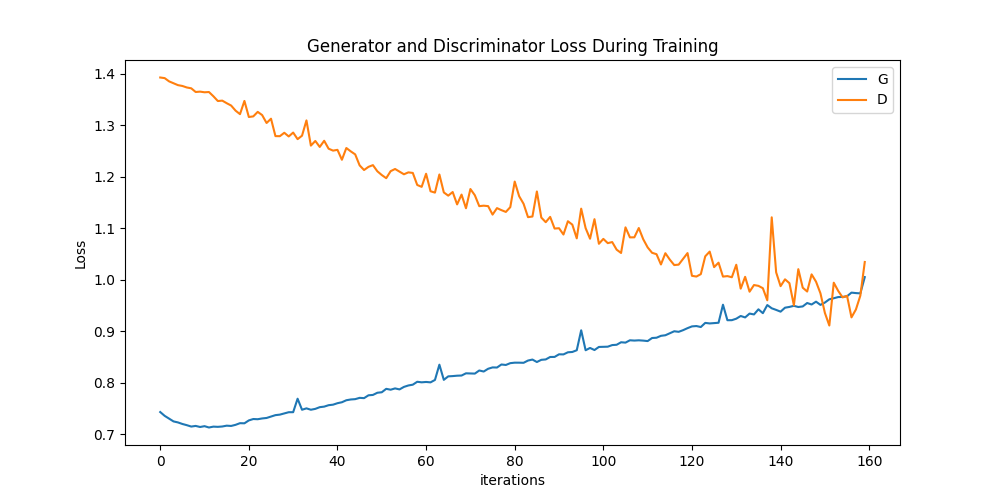

In [60]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


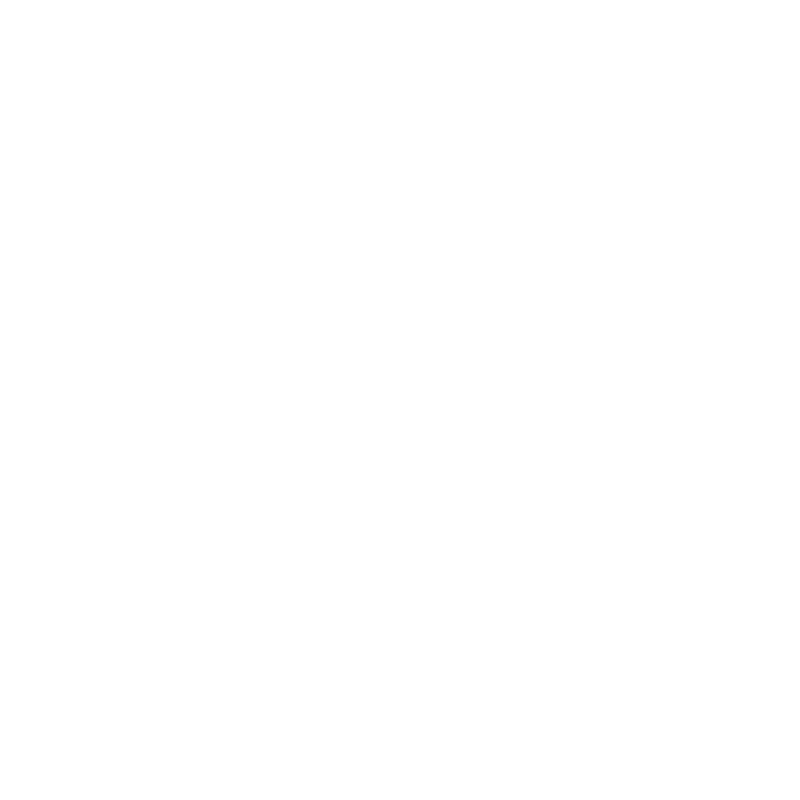

In [61]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())